In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
path = 'agri_data/'

# Preprocessing

In [3]:
df = pd.read_csv('agri_label.csv')

In [4]:
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,agri_0_9354.jpeg,512,512,weed,63,120,425,442
1,agri_0_9354.jpeg,512,512,weed,0,1,180,148
2,agri_0_7574.jpeg,512,512,crop,95,167,453,469
3,agri_0_8960.jpeg,512,512,weed,52,76,422,353
4,agri_0_417.jpeg,512,512,weed,7,75,511,411


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2072 entries, 0 to 2071
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  2072 non-null   object
 1   width     2072 non-null   int64 
 2   height    2072 non-null   int64 
 3   class     2072 non-null   object
 4   xmin      2072 non-null   int64 
 5   ymin      2072 non-null   int64 
 6   xmax      2072 non-null   int64 
 7   ymax      2072 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 129.6+ KB


now checking all labeled images are available in the folder or not 

In [6]:
folder_images = os.listdir('agri_data/')

In [7]:
len(folder_images)

1300

In [8]:
train_images = folder_images[:1000]

In [9]:
test_images = folder_images[1000:]

In [10]:
j=0
for i in tqdm(list(df['filename'].unique())):
    if i in folder_images:
        j+=1
print(j)        

100%|███████████████████████████████████████████████████████████████████████████| 1300/1300 [00:00<00:00, 51306.47it/s]

1300


# Visualizing the Dataset

16it [00:00, 64.73it/s]


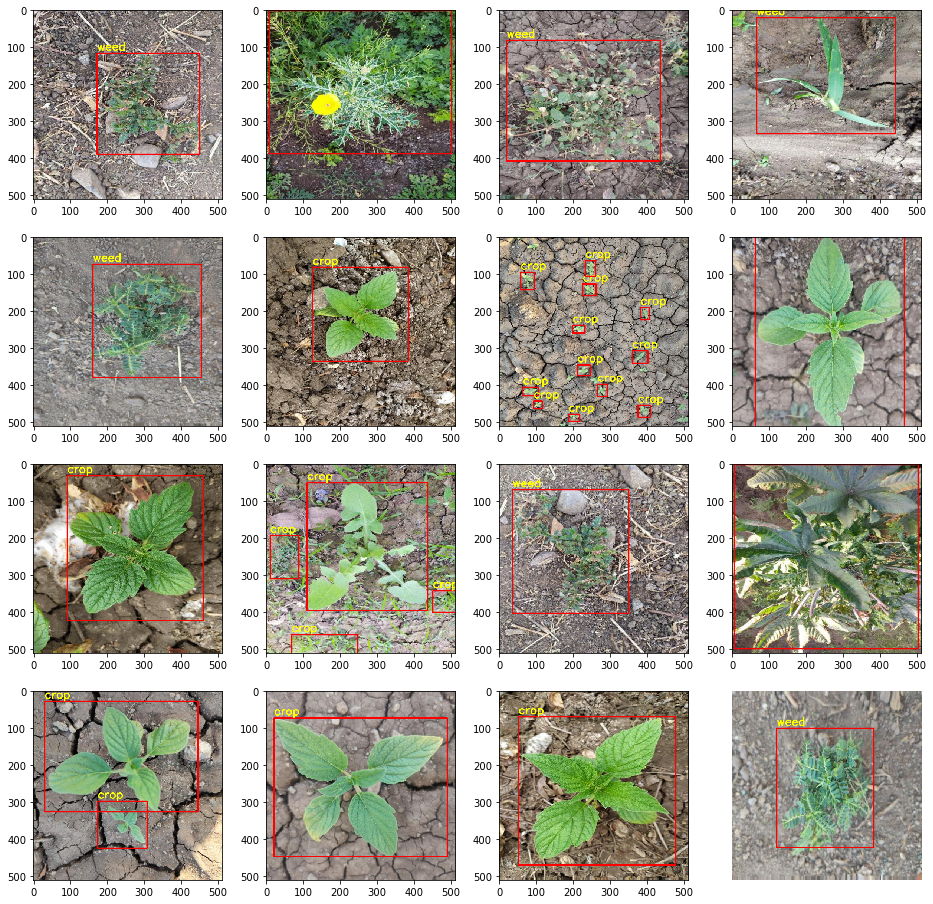

In [11]:
_ , axes = plt.subplots(4,4,figsize=(16,16))
for i,ax in tqdm(zip(range(16),axes.flat)):
    temp_df = df[df['filename']==folder_images[i]].reset_index(drop=True)
    temp_img = cv2.imread(path+folder_images[i])
    temp_img = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)
    for j in range(len(temp_df)):
        rect = cv2.rectangle(temp_img,(temp_df.loc[j,'xmin'],temp_df.loc[j,'ymin']),(temp_df.loc[j,'xmax'],temp_df.loc[j,'ymax']),(255,0,0),2,cv2.LINE_AA)
        rect_text = cv2.putText(rect,temp_df.loc[j,'class'],(temp_df.loc[j,'xmin'],temp_df.loc[j,'ymin']-8), cv2.FONT_HERSHEY_SIMPLEX,1, (255,255,0), 2, cv2.LINE_AA)
    ax.imshow(rect_text)
    plt.axis('off')


# Selective search

In [12]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [13]:
img = cv2.imread(path+folder_images[45])
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
rects = ss.process()

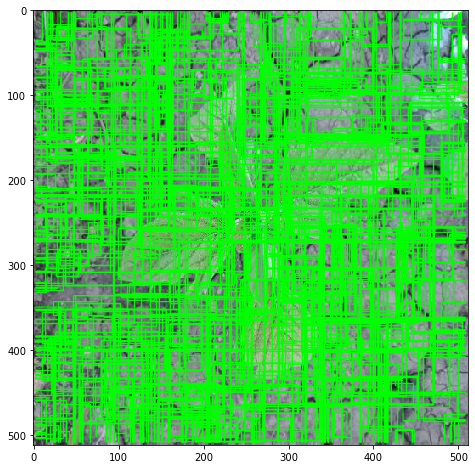

In [14]:
sel_rects = rects[:1200]
imOut = img.copy()
for i, rect in (enumerate(sel_rects)):
    x, y, w, h = rect
#     print(x,y,w,h)
#     imOut = imOut[x:x+w,y:y+h]
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
plt.figure(figsize=(8,8))
plt.imshow(imOut)

# Define some function
Now we use our defined function for getting region proposal from images. In this function we just have to add image path and dataframe which contain true label of that image in ['filename','width','height','class','xmin','ymin','xmax','ymax'] this format.

# Check for one image

In [15]:
from region_proposals import iou_filter

In [16]:
ss,neg =iou_filter(path+folder_images[888],df,thresh=0.5)

Now visualize only region which have IoU greater than 0.5

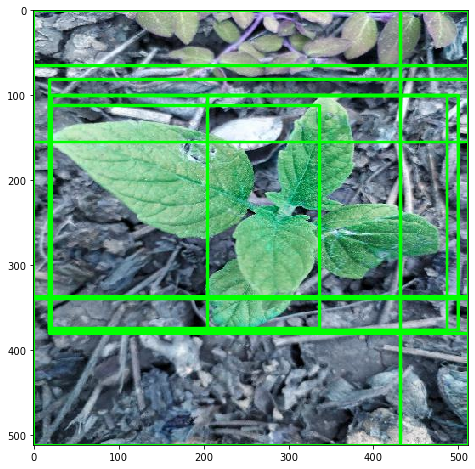

In [17]:
img = cv2.imread(path+folder_images[888])
for i, rect in (enumerate(ss)):
    x, y, w, h = rect[0]
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2, cv2.LINE_AA)
    
plt.figure(figsize=(12,8))
plt.imshow(img)

In [18]:
len(neg)

21

Regions which has iou < 0.3 Which will use for background class training in CNN

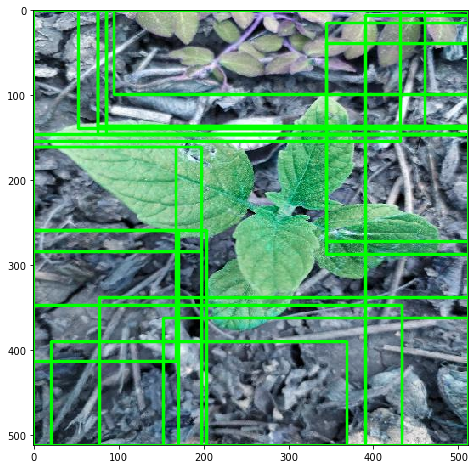

In [20]:
img = cv2.imread(path+folder_images[888])
for i, rect in (enumerate(neg)):
    x, y, w, h = rect
    
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2, cv2.LINE_AA)
    
    
plt.figure(figsize=(12,8))
plt.imshow(img)

# Saving all region proposal of all images

In [21]:
train_data = {}
test_data  = {}

This will take arround 2 hour to process

In [22]:
for i,img in tqdm(enumerate(train_images)):
    ss,neg =iou_filter(path + img , df , thresh=0.5)
    train_data[img] = {'region_proposal':ss,'negative_example':neg}

1000it [57:12,  3.43s/it]


In [23]:
for i,img in tqdm(enumerate(test_images)):
    ss,neg =iou_filter(path + img , df , thresh=0.5)
    test_data[img] = {'region_proposal':ss,'negative_example':neg}

300it [16:53,  3.38s/it]


In [24]:
import json
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)

In [25]:
with open('train.json','w+') as output_file:
    json.dump(train_data,output_file,cls=MyEncoder)

In [26]:
with open('test.json','w+') as output_file:
    json.dump(test_data,output_file,cls=MyEncoder)

checking our conversion is right or wrong

In [27]:
with open('train.json') as train:
    train_json = json.load(train)

In [28]:
with open('test.json') as test:
    test_json = json.load(test)

In [29]:
train_json == train_data

True

In [30]:
test_json == test_data

True